# Figure PSTH MC
Dans celui-ci aussi j'ai fixé les seeds de génération des patrons aléatoires, sur le meme modèle que celui des gratings

# Extracting photodiode data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt
from tqdm import tqdm
import csv

In [2]:
subfolder = 'E006_a17/'

In [3]:
dataset = kt.load(subfolder+'/experiment1_100.raw.kwd',
                  'all')

info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

In [4]:
print('Timestamps shape', timestamps.shape)
print('Timestamps range from %s to %s' % (timestamps.min(), timestamps.max()))
print('Which should be %s seconds' % (timestamps.max() - timestamps.min()))

Timestamps shape (30576600,)
Timestamps range from 5783.48 to 6802.699966666667
Which should be 1019.2199666666675 seconds


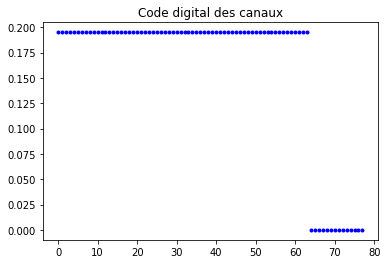

In [5]:
plt.plot(channels, '.b')
plt.title('Code digital des canaux')
plt.show()
plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(data[:,35][::10], linewidth=1)
plt.title("Photodiode signal, zoom on a peak, get the amplitude and the inter peak and multiply by 100")
plt.show()

plt.plot(data[:,70][::10])
plt.pause(.1)
plt.close('all')

In [6]:
photodiode_channel = data[:, 70]
del data

In [7]:
# https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
def grouper(iterable, timeframe):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= timeframe:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


above_threshold = np.where(photodiode_channel > 1700)[0]
chunk_list = list(enumerate(grouper(above_threshold, 600), 1))
print('Found %s chunks' % len(chunk_list))

Found 481 chunks


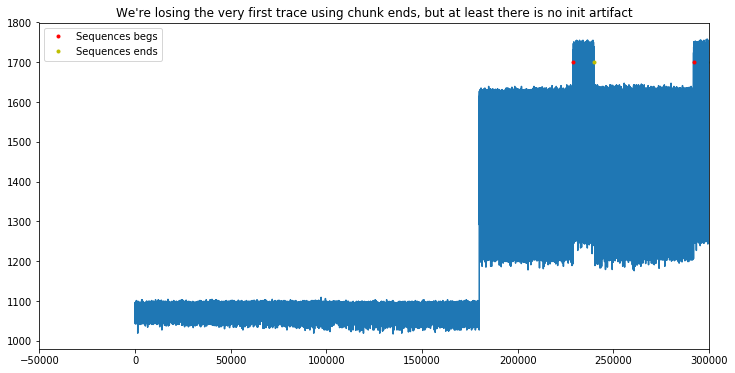

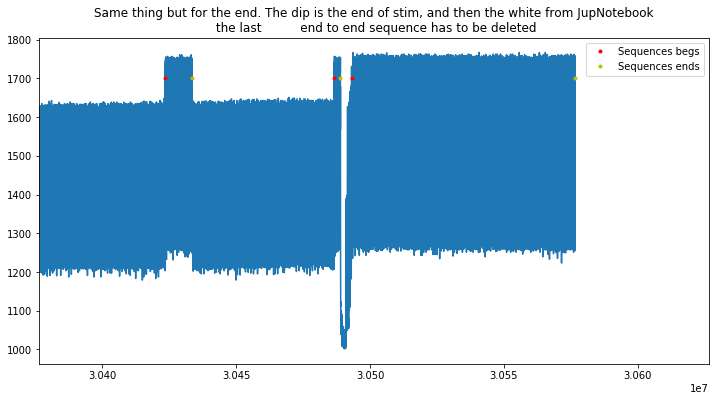

In [8]:
chunk_beg_list = []
chunk_end_list = []
min_timestamps = timestamps.min()

for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0])  # /30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1])  # /30000+min_timestamps)

plt.figure(figsize=(12, 6))
plt.plot(photodiode_channel[:9000000])
plt.plot(chunk_beg_list[:65], np.full_like(chunk_beg_list[:65], 1700), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[:65], np.full_like(chunk_end_list[:65], 1700), '.y',
         label='Sequences ends')
plt.legend()
#plt.xlim(100000/2, 380000/2)
plt.xlim(-50000, 300000)
plt.title("We're losing the very first trace using chunk ends, but at least there is no init artifact")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(len(photodiode_channel)-900000, len(photodiode_channel), 900000),
         photodiode_channel[-900000:])
plt.plot(chunk_beg_list[-25:], np.full_like(chunk_beg_list[-25:], 1700), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[-25:], np.full_like(chunk_end_list[-25:], 1700), '.y',
         label='Sequences ends')
plt.legend()
plt.xlim(len(photodiode_channel)-200000, len(photodiode_channel)+50000)
plt.title("Same thing but for the end. The dip is the end of stim, and then the white from JupNotebook\n the last\
          end to end sequence has to be deleted")
plt.show()

plt.close('all')

# rerunning the chunk lists with sample rate converted to actual time
chunk_beg_list = []
chunk_end_list = []
for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0]/30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1]/30000+min_timestamps)

# we remove the un-needed last sequence
del chunk_end_list[-1]
del chunk_beg_list[-1]

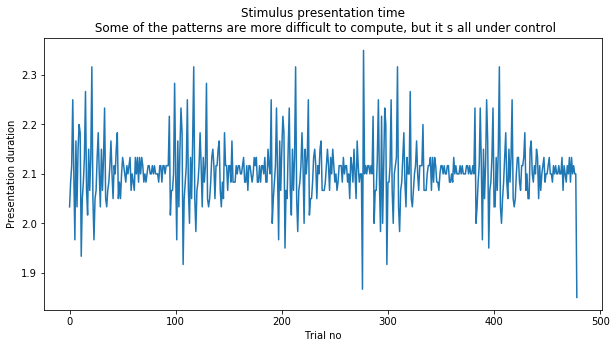

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.asarray(chunk_end_list[1:]) - np.asarray(chunk_end_list[:-1]))
plt.title('Stimulus presentation time\n Some of the patterns are more difficult to compute, but it s all under control')
plt.xlabel('Trial no')
plt.ylabel('Presentation duration')
plt.show()

# Extracting spike times from clusters 

In [10]:
spike_times = np.load(subfolder+'spike_times.npy')
spike_clusters = np.load(subfolder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(subfolder+'./cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))

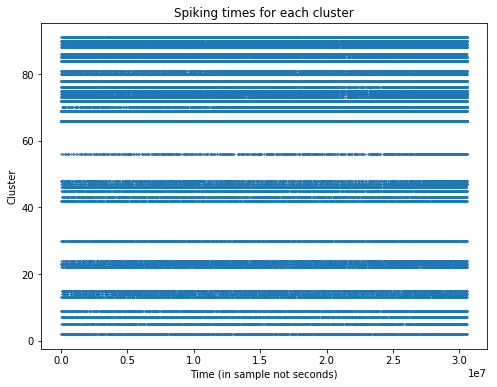

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(*zip(*spike_cluster_table), s=1)
plt.xlabel('Time (in sample not seconds)')
plt.ylabel('Cluster')
plt.title('Spiking times for each cluster')
plt.show()

In [12]:
good_spikes = []

for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0]/30000+min_timestamps)

    good_spikes.append(temp_lst)

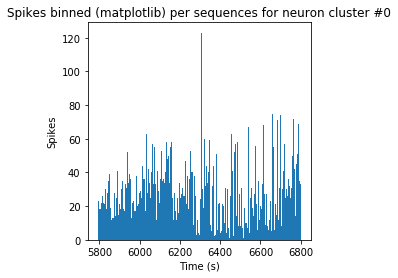

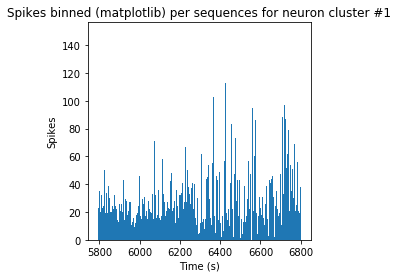

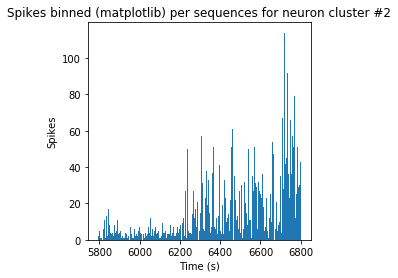

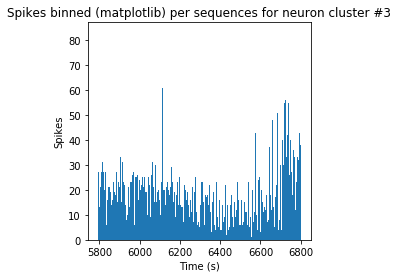

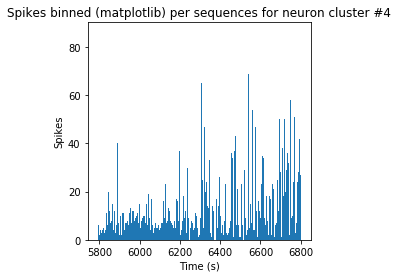

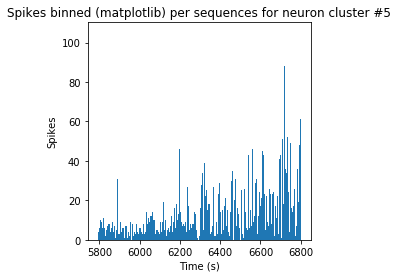

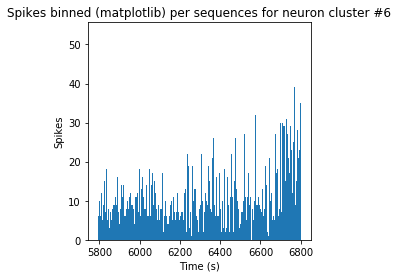

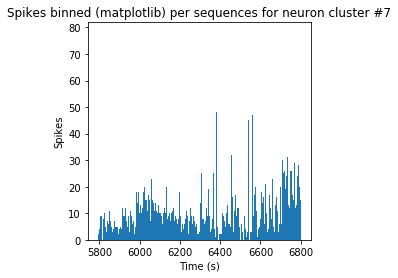

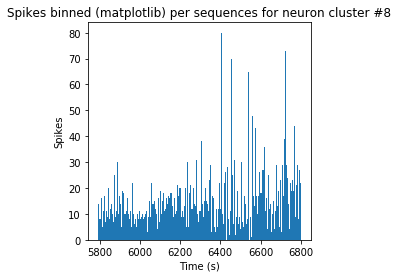

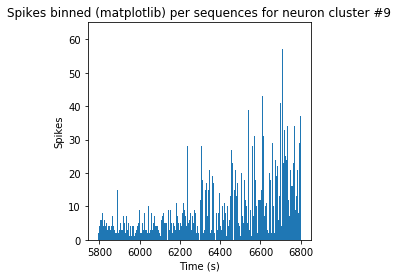

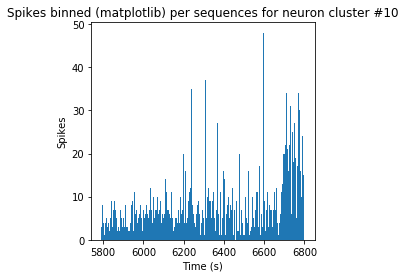

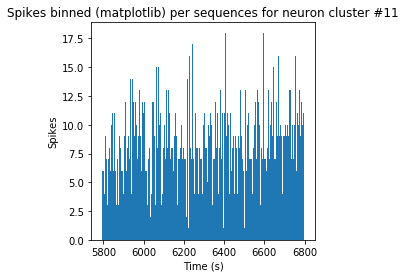

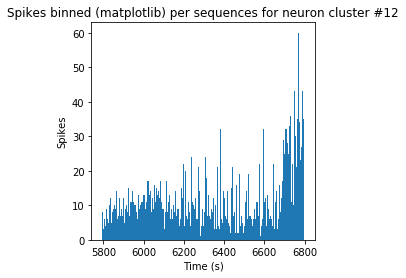

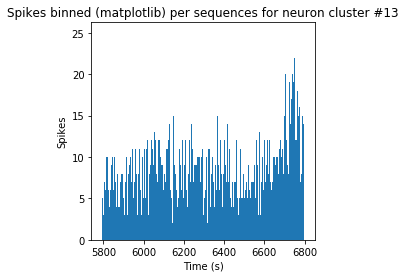

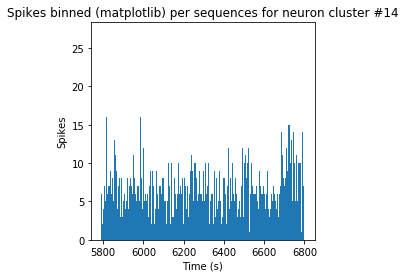

In [13]:
hist_list = []
for it, cluster in enumerate(good_spikes):
    plt.figure(figsize=(4, 4))
    hist = plt.hist(cluster, bins=chunk_end_list)
    hist_list.append(hist[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Spikes')
    plt.title('Spikes binned (matplotlib) per sequences for neuron cluster #%s' % it)
    plt.show()
    plt.pause(.1)

plt.close('all')

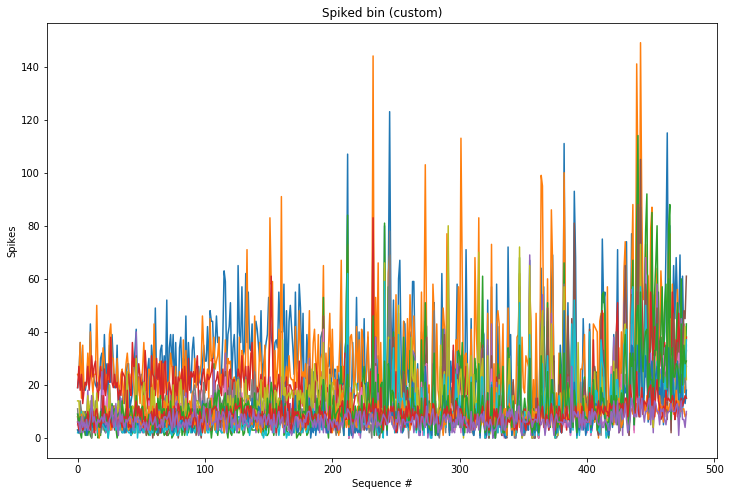

In [14]:
#CAREFUL !!!!!!
# With MC one stimulus is end-end, not end-beg
plt.figure(figsize=(12, 8))
cluster_spike_bins = []
for cluster in good_spikes:
    spike_bins = []

    for i in range(len(chunk_end_list)-1):
        where = np.where(
            (cluster >= chunk_end_list[i]) & (cluster <= chunk_end_list[i+1]))[0]
        spike_bins.append(len(where))

    plt.ylabel('Spikes')
    plt.xlabel('Sequence #')
    plt.title('Spiked bin (custom)')
    plt.plot(spike_bins)
    cluster_spike_bins.append(spike_bins)

In [15]:
plt.close('all')

# Linking the results with the stimulation
For the gratings I don't have a stim file but I saved and controlled the code for each sequence, so I can re-generate it

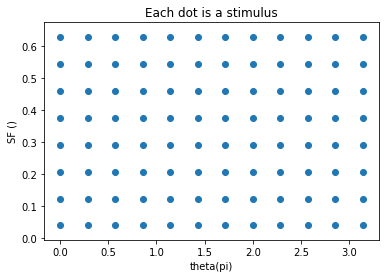

In [16]:
import itertools

# Orientations
N_thetas = 12
# we offset by pi/2 to prevent problems with matplotlib's displays and psychopy
thetas = np.linspace(0, np.pi, N_thetas)

# Noise
B_thetas = np.linspace(np.pi/2, np.pi/32, 8)/2.5
# Presentation of each pattern
stim_duration = .02  # s

# Repetition of each block
repetition = 5

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))

plt.scatter(*zip(*sequence))
plt.title('Each dot is a stimulus')
plt.xlabel('theta(pi)')
plt.ylabel('SF ()')
plt.show()

In [17]:
sorted_by_btheta = sorted(sequence, key=lambda tup: tup[1], reverse=True)
sorted_by_btheta
sequence = sorted_by_btheta

In [18]:
full_sequences = sequence.copy()
for rep in range(repetition-1):
    full_sequences += sequence

In [19]:
del full_sequences[0]

In [20]:
len(full_sequences) == len(chunk_end_list)

False

In [21]:
len(cluster_spike_bins[0])

479

In [22]:
# n sequences is n-1 bins
(len(sequence)*5)-1 == len(cluster_spike_bins[0])

True

In [23]:
seq_FR_list = []
for it, cluster in enumerate(cluster_spike_bins):
    # print(it) #cluster number
    temp_list = []  # list of sequence info with firing rate
    for it2, sequence in enumerate(full_sequences):
        # print(it2) #sequence number
        i = it2-1
        FR = cluster[i] / (chunk_end_list[i+1] - chunk_end_list[i])
        temp_list.append((sequence, FR))

    seq_FR_list.append(temp_list)

In [24]:
all_unique_tuple_FR_list = []

for cluster in seq_FR_list:
    uniqs = np.unique(np.asarray(cluster)[:, 0])
    # first element is sequence info (theta,cpd) and second is FR summed on 5 repetitions
    unique_tuple_FR_list = []
    for unique_tuple in uniqs:
        sum_list = []
        for seq_fr in cluster:
            if seq_fr[0] == unique_tuple:
                sum_list.append(seq_fr[1])
        seq_sum = np.sum(sum_list)
        unique_tuple_FR_list.append((unique_tuple, seq_sum))

    all_unique_tuple_FR_list.append(unique_tuple_FR_list)

In [25]:
uniq_theta = thetas.copy()
uniq_b_theta = B_thetas.copy()

In [26]:
all_unique_tuple_FR_list[0]

[((0.0, 0.039269908169872414), 55.60587202202483),
 ((0.0, 0.12341971139102767), 78.59021920286388),
 ((0.0, 0.20756951461218281), 78.81189015242434),
 ((0.0, 0.291719317833338), 83.38661291102474),
 ((0.0, 0.37586912105449316), 59.0972949541988),
 ((0.0, 0.4600189242756483), 52.30294171081595),
 ((0.0, 0.5441687274968035), 80.42616494469162),
 ((0.0, 0.6283185307179586), 93.80494917592128),
 ((0.28559933214452665, 0.039269908169872414), 52.30596175478135),
 ((0.28559933214452665, 0.12341971139102767), 70.38395200600054),
 ((0.28559933214452665, 0.20756951461218281), 72.16446639058239),
 ((0.28559933214452665, 0.291719317833338), 68.7848440037623),
 ((0.28559933214452665, 0.37586912105449316), 48.0766483593028),
 ((0.28559933214452665, 0.4600189242756483), 54.476419558985704),
 ((0.28559933214452665, 0.5441687274968035), 40.984275883296164),
 ((0.28559933214452665, 0.6283185307179586), 58.8557015618692),
 ((0.5711986642890533, 0.039269908169872414), 91.37624339295925),
 ((0.57119866428

# Global tuning curve (taking in account all noise levels)

In [27]:
from lmfit import Model, Parameters


def tuning_function(x, j, B, fmax):  # von mises, baseline is the minimum neuron activity
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(array, datacol='.b', fitcol='k', data_kws=None, do_title=True,
             seq_nbr=None):

    # fit the gaussian
    x = np.linspace(0, len(array), len(array))
    y = array
    N = len(array)

    #mod = GaussianModel()

    mod = Model(tuning_function)
    pars = Parameters()
    y = y-np.min(y)
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 100.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    '''# plot the fits
    out.plot_fit(datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)'''
    #print(out.fit_report())
    sigma = out.best_values['B']

    '''    
    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$B_\theta$ = %.2f' % sigma)'''

    return out.best_values

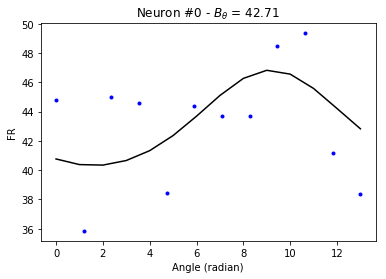

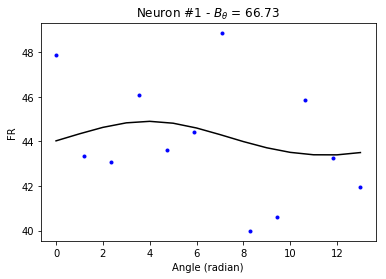

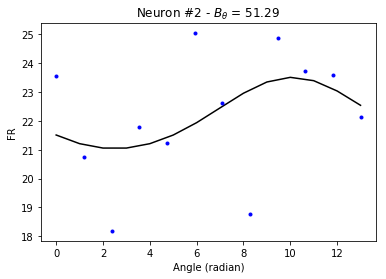

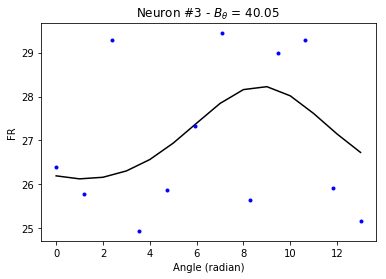

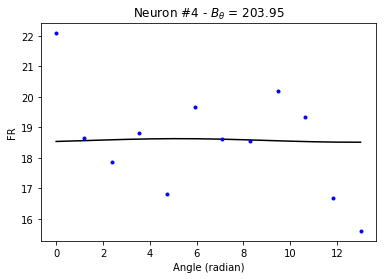

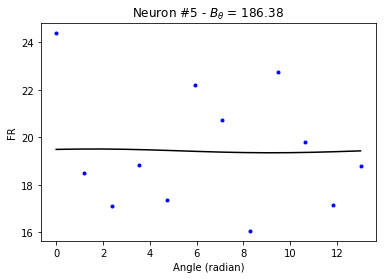

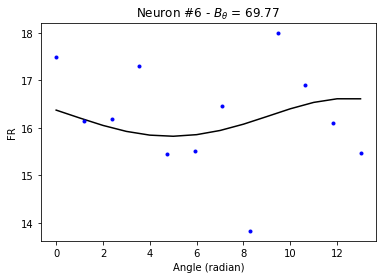

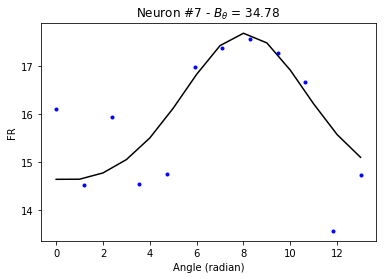

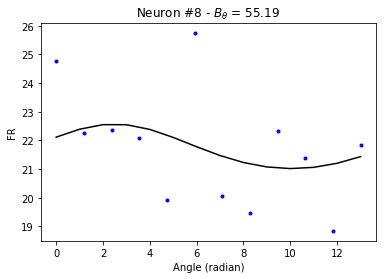

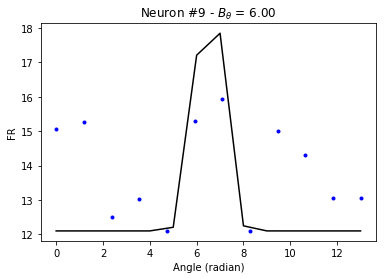

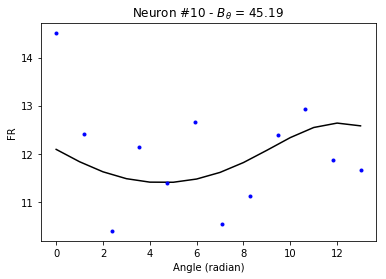

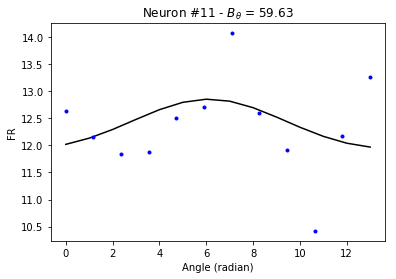

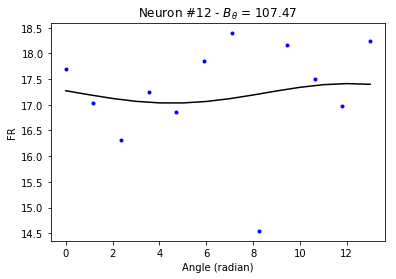

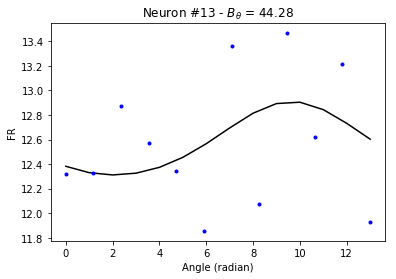

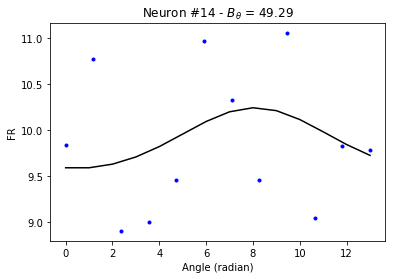

In [28]:
# we can sum along theta, which is likely to be uninformative due to noise in certains patterns
for it, neuron in enumerate(all_unique_tuple_FR_list):
    FR_sum = []
    for thetas in uniq_theta:
        theta_sum_list = []
        for tup_fr in neuron:
            if tup_fr[0][0] == thetas:
                theta_sum_list.append(tup_fr[1])

        FR_sum.append(np.sum(theta_sum_list))

    #plt.plot(uniq_theta, np.asarray(FR_sum)/(5+8), '.k')
    best_vals = fit_plot(np.asarray(FR_sum)/(5+8))
    
    plt.plot(tuning_function(x=np.linspace(0, len(FR_sum), len(FR_sum)+2),
                             j=best_vals['j'], fmax=best_vals['fmax'],
                             B=best_vals['B'])+(np.asarray(FR_sum)/(5+8)).min(),
            c = 'k')
    
    plt.plot(np.linspace(0, len(FR_sum)+1, len(FR_sum)), np.asarray(FR_sum)/(5+8), '.b')
    
    plt.ylabel('FR')
    plt.xlabel('Angle (radian)')
    plt.title('Neuron #%s - ' % it + r'$B_\theta$ = %.2f'%best_vals['B'])
    plt.show()
    plt.close('all')

# Angle and noise dissociated (so 8 tuning curves per neuron)

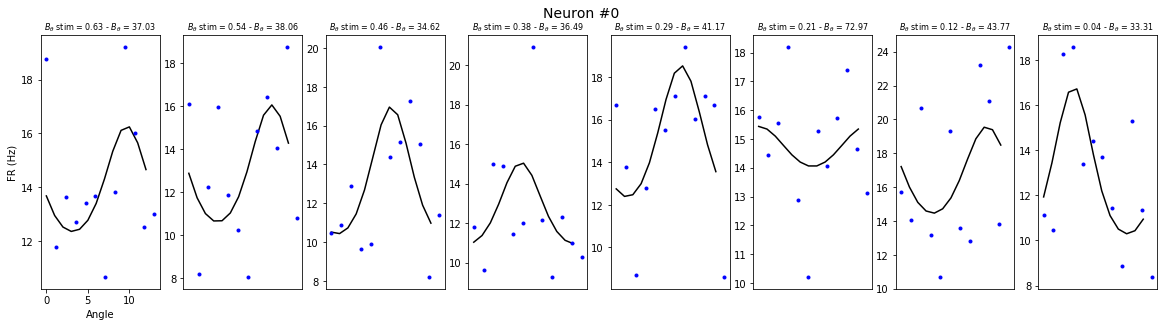

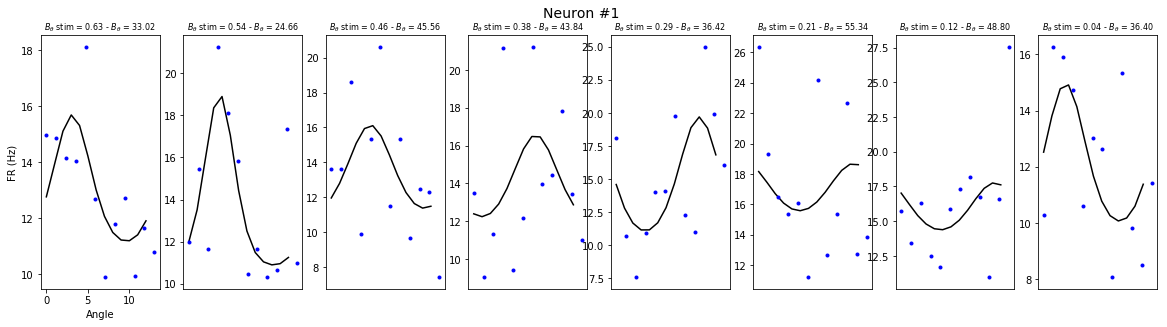

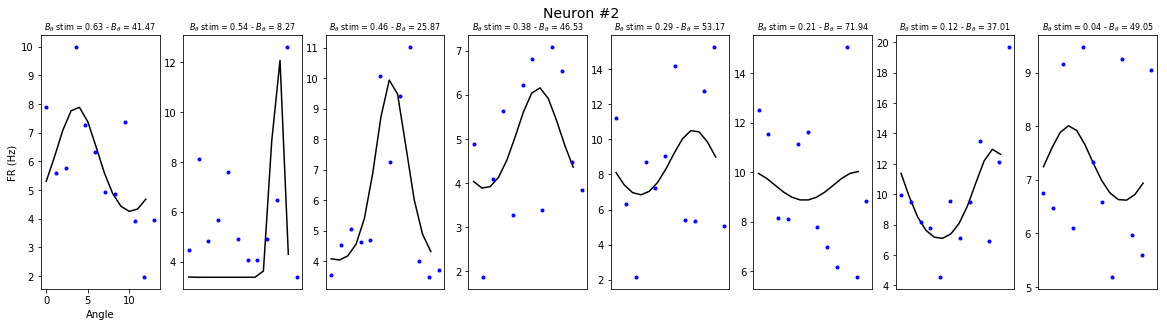

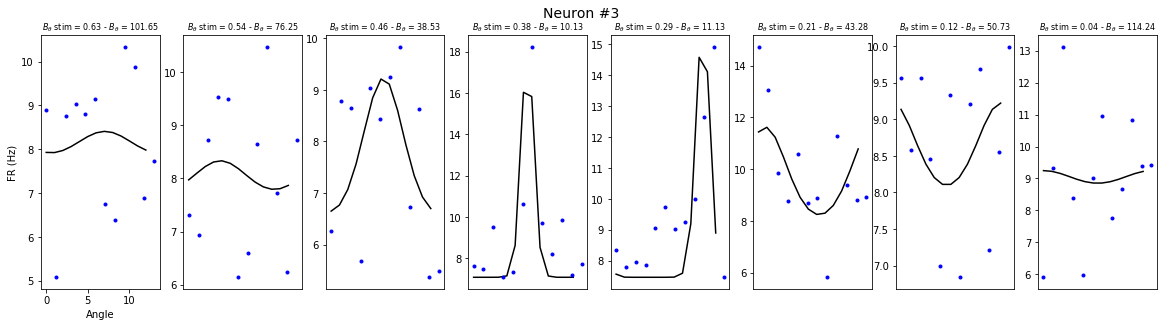

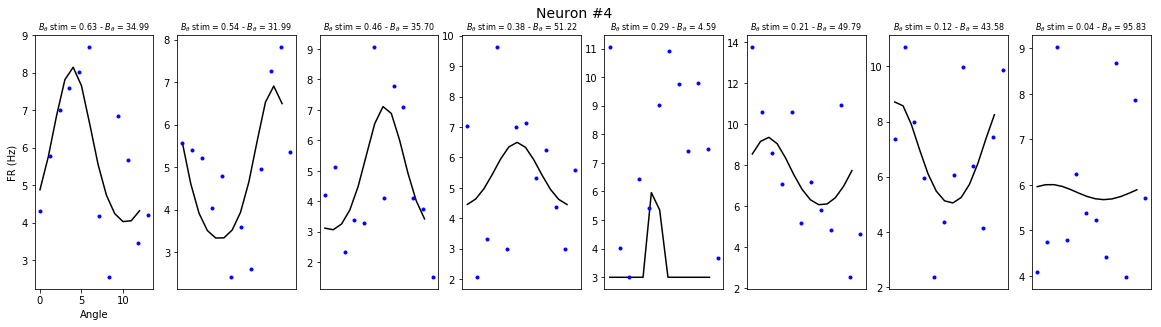

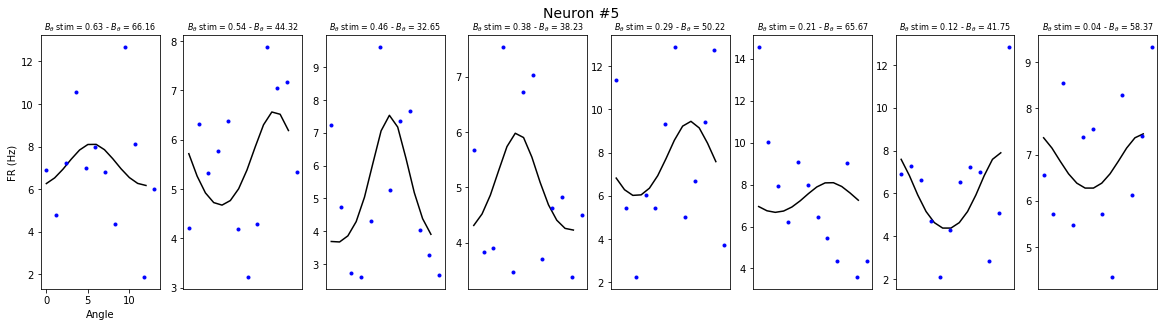

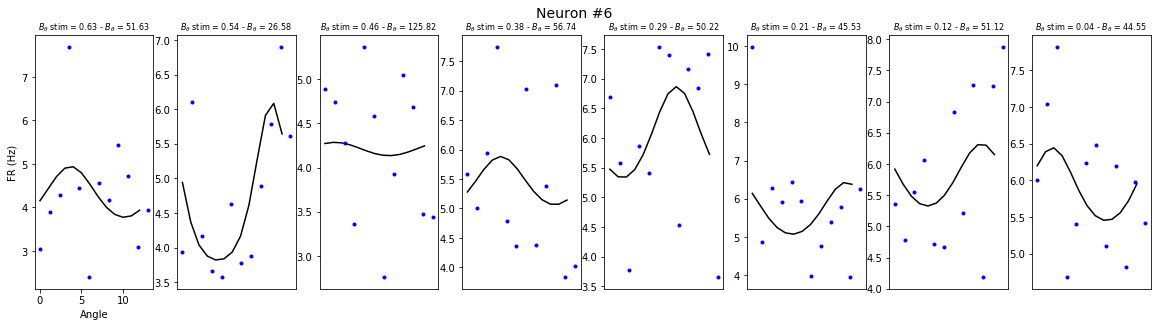

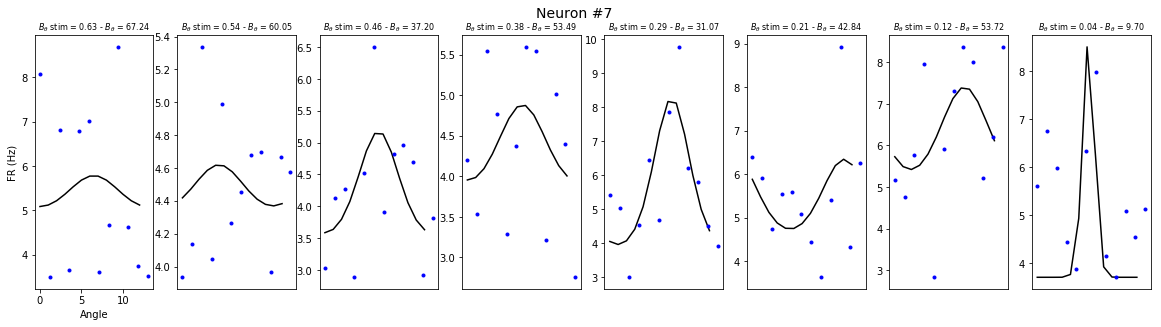

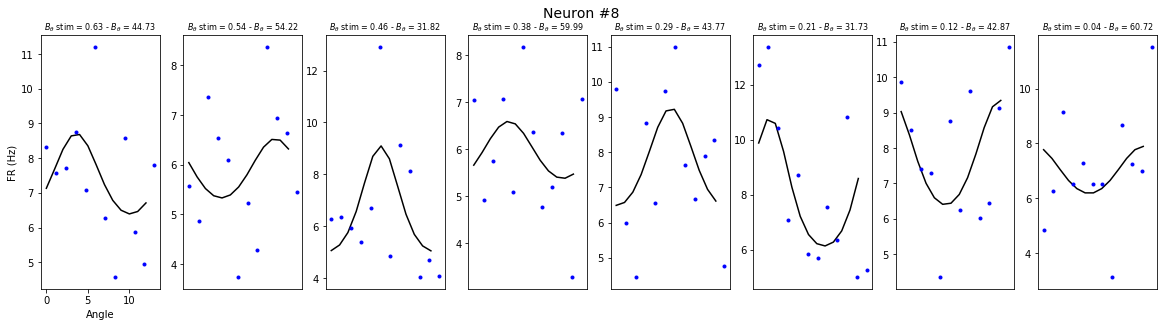

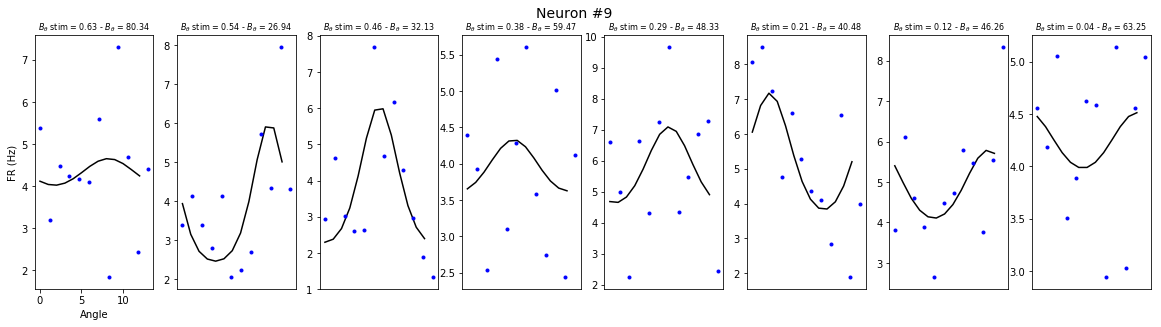

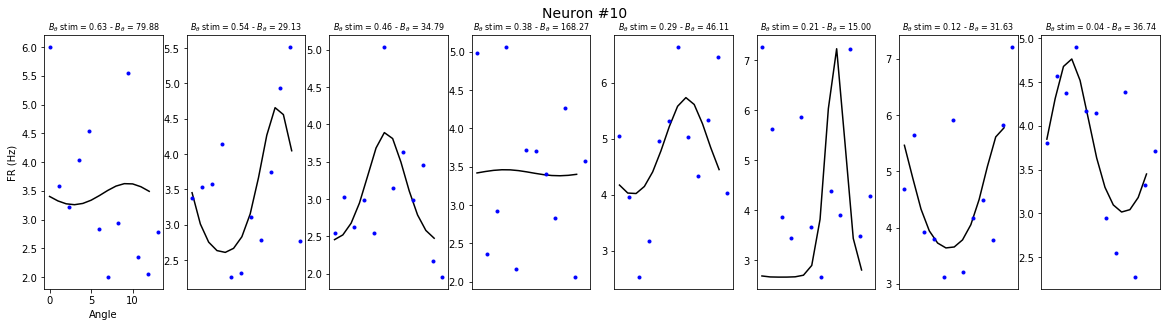

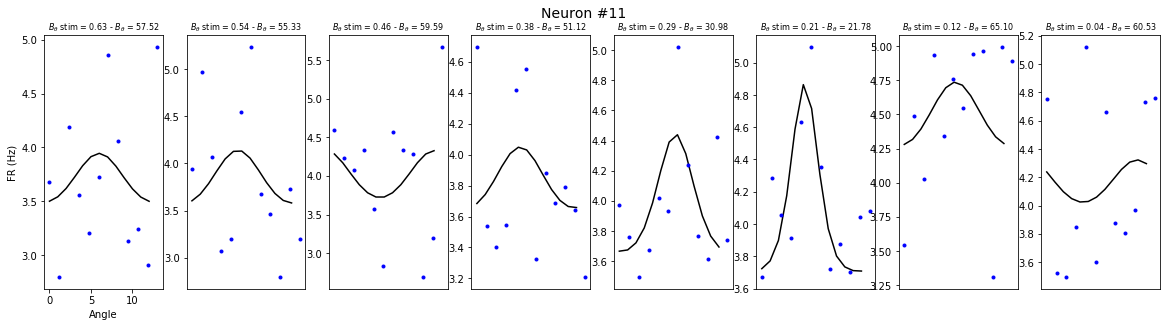

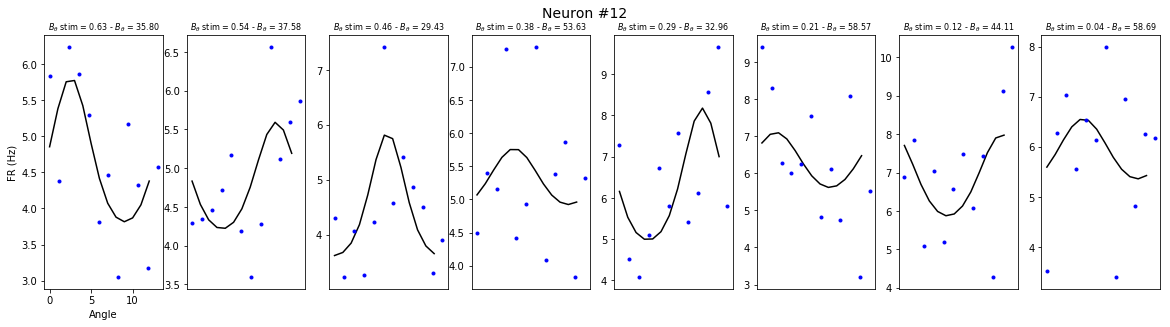

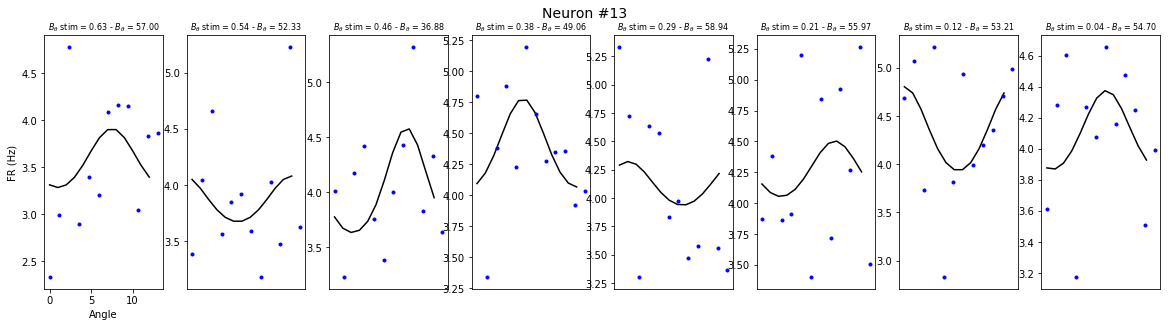

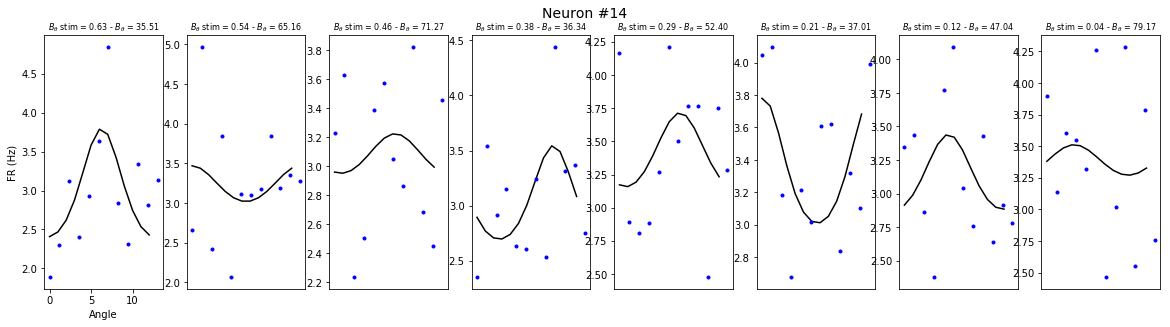

In [29]:
# we can sum along theta, which is likely to be uninformative due to noise in certains patterns
for it, neuron in enumerate(all_unique_tuple_FR_list):
    fig = plt.figure(figsize=(20, 4))
    for it2, b_thetas in enumerate(uniq_b_theta):
        FR_sum = []
        for thetas in uniq_theta:
            theta_sum_list = []
            for tup_fr in neuron:
                if tup_fr[0][0] == thetas and tup_fr[0][1] == b_thetas:
                    theta_sum_list.append(tup_fr[1])

            FR_sum.append(np.sum(theta_sum_list))

        plt.subplot(1, len(uniq_b_theta), it2+1)
        best_vals = fit_plot(np.asarray(FR_sum)/(5))
    
        plt.plot(tuning_function(x=np.linspace(0, len(FR_sum), len(FR_sum)+1),
                                 j=best_vals['j'], fmax=best_vals['fmax'],
                                 B=best_vals['B'])+(np.asarray(FR_sum)/(5)).min(),
                c = 'k')

        plt.plot(np.linspace(0, len(FR_sum)+1, len(FR_sum)), np.asarray(FR_sum)/(5), '.b')
        
        plt.title(r'$B_\theta$ stim = %.2f - '% b_thetas + r'$B_\theta$ = %.2f'% (best_vals['B']), fontsize=8)
        
        if it2 == 0:
            plt.ylabel('FR (Hz)')
            plt.xlabel('Angle')

        if it2 > 0:
            plt.xticks([])
            #plt.yticks([])

    plt.subplots_adjust(bottom=0, wspace=0.2, hspace=0)
    plt.suptitle('Neuron #%s' % it, fontsize=14)
plt.show()
plt.close('all')

# PSTH of one neuron

# Preferred orientation

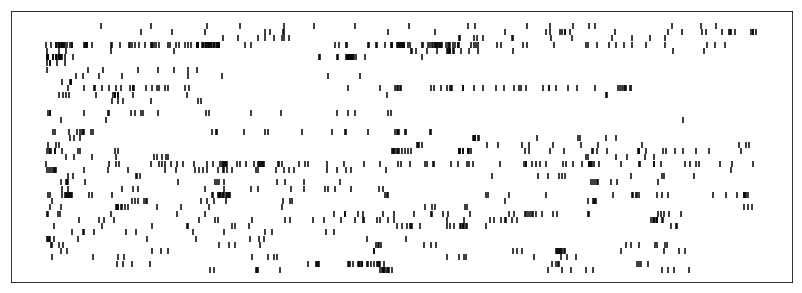

In [30]:
the_chosen_one = 1 #best looking neuron for a PSTH
max_FR_angle = 9
max_FR_btheta = 1

cluster = good_spikes[the_chosen_one]

all_PSTH_spikes = []
for it, sequence in enumerate(full_sequences):
    if sequence[0] == uniq_theta[max_FR_angle] :# and sequence[1] == uniq_b_theta[max_FR_btheta] :
        spike_times_PS = []
        where = np.where(
                (cluster >= chunk_end_list[it]-.5) & (cluster <= chunk_end_list[it]+1.5))[0]
        spike_times_PS.append(where)
        
        all_PSTH_spikes.append(spike_times_PS)
#for spike_times in good_spikes[the_chosen_one]

times_per_trial = [] 
for trial in  all_PSTH_spikes :
    trial_list = []
    for ID in trial[0] :
        trial_list.append(cluster[ID])
    times_per_trial.append(trial_list)
    
    
fig = plt.figure(figsize = (14,5))

for it,trial in enumerate(times_per_trial) :
    for it2, spike_times in enumerate(trial) :
        if it2 !=0 :
            plt.scatter(spike_times-min(trial)-.5, it+1 ,
                        c = 'k', marker = '|',
                       linewidth = 1.5)
        #plt.axhline((it+1)*.05, c = 'r')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.yticks([])
fig.savefig('PSTH_MC_pref.svg', format = 'svg', transparent = True, bbox_inches = 'tight')
plt.show()
plt.close('all')

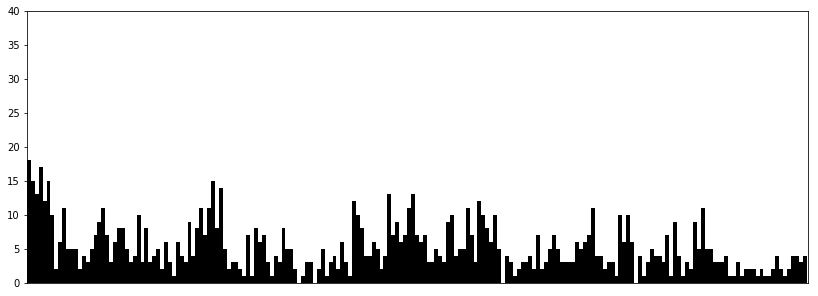

In [31]:
fig = plt.figure(figsize = (14,5))

hist_list = []
for trial in times_per_trial :
    if len(trial) >= 1 : #we can sometime have null trials
        hist_list.append(np.asarray(trial)-min(trial)-.5)
    
concat = np.concatenate(hist_list) 
plt.hist(concat, 200, color = 'k')
plt.xlim(-.49, 1.5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(0,40)
fig.savefig('PSTH_hist_MC_pref.svg', format = 'svg', transparent = True, bbox_inches = 'tight')
plt.show()

# Non-preferred orientation

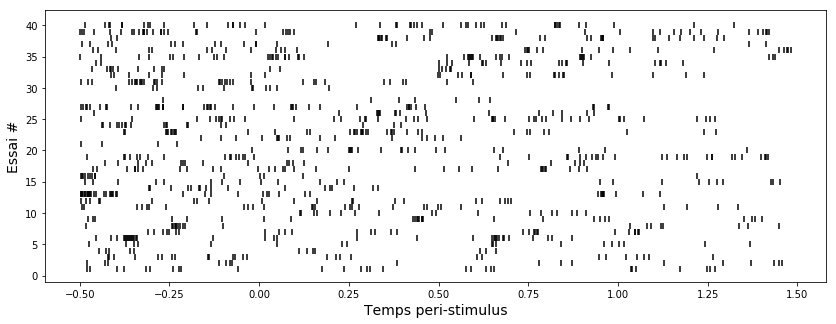

In [32]:
max_FR_angle = 1
max_FR_btheta = 1

cluster = good_spikes[the_chosen_one]

all_PSTH_spikes = []
for it, sequence in enumerate(full_sequences):
    if sequence[0] == uniq_theta[max_FR_angle] :# and sequence[1] == uniq_b_theta[max_FR_btheta] :
        spike_times_PS = []
        where = np.where(
                (cluster >= chunk_end_list[it]-.5) & (cluster <= chunk_end_list[it]+1.5))[0]
        spike_times_PS.append(where)
        
        all_PSTH_spikes.append(spike_times_PS)
#for spike_times in good_spikes[the_chosen_one]

times_per_trial = [] 
for trial in  all_PSTH_spikes :
    trial_list = []
    for ID in trial[0] :
        trial_list.append(cluster[ID])
    times_per_trial.append(trial_list)
    
    
fig = plt.figure(figsize = (14,5))

for it,trial in enumerate(times_per_trial) :
    for it2, spike_times in enumerate(trial) :
        if it2 !=0 :
            plt.scatter(spike_times-min(trial)-.5, it+1 ,
                        c = 'k', marker = '|',
                       linewidth = 1.5)
        #plt.axhline((it+1)*.05, c = 'r')

plt.xlabel('Temps peri-stimulus', fontsize = 14)
plt.ylabel('Essai #', fontsize = 14)
fig.savefig('PSTH_MC_nonpref.svg', format = 'svg', transparent = True, bbox_inches = 'tight')
plt.show()
plt.close('all')

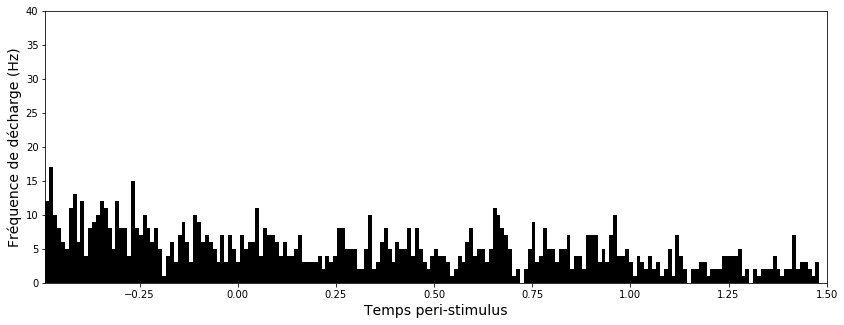

In [33]:
fig = plt.figure(figsize = (14,5))

hist_list = []
for trial in times_per_trial :
    if len(trial) >= 1 : #we can sometime have null trials
        hist_list.append(np.asarray(trial)-min(trial)-.5)
    
concat = np.concatenate(hist_list) 
plt.hist(concat, 200, color = 'k')
plt.xlim(-.49, 1.5)
plt.ylim(0,40)
plt.xlabel('Temps peri-stimulus', fontsize = 14)
plt.ylabel('Fréquence de décharge (Hz)', fontsize = 14)
fig.savefig('PSTH_hist_MC_nonpref.svg', format = 'svg', transparent = True, bbox_inches = 'tight')
plt.show()

# The neuron finder

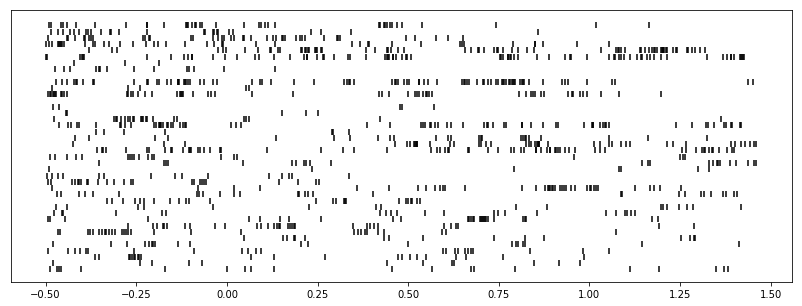

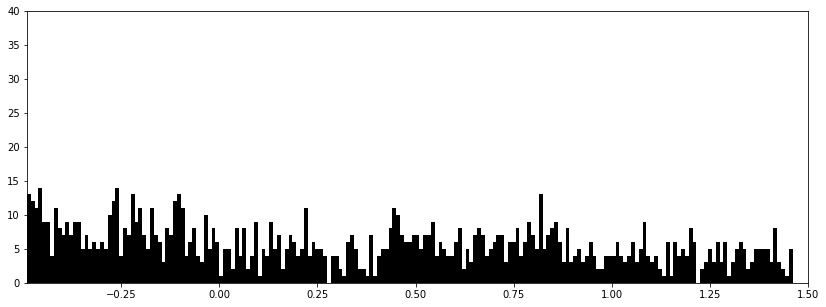

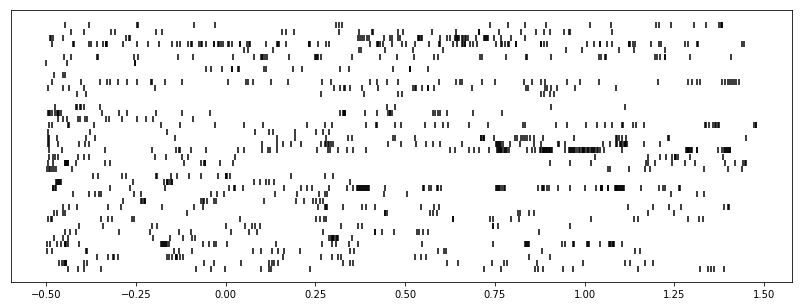

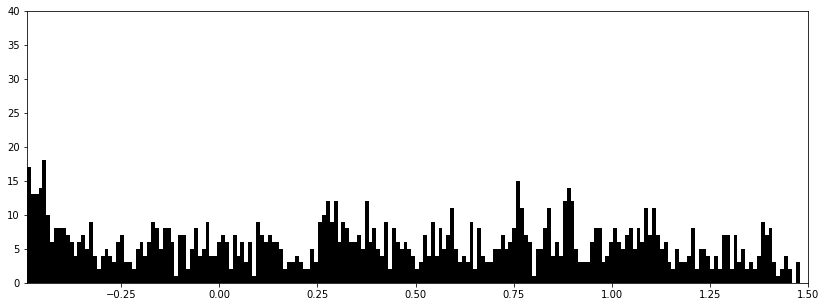

KeyboardInterrupt: 

In [43]:
for neuron_cluster in good_spikes : #best looking neuron for a PSTH
    max_FR_angle = 5
    max_FR_btheta = 1
    thresh_b_theta = 3 #we only consider b_thetas below that

    cluster = neuron_cluster

    all_PSTH_spikes = []
    for it, sequence in enumerate(full_sequences):
        if sequence[0] == uniq_theta[max_FR_angle] :# and sequence[1] == uniq_b_theta[max_FR_btheta] :
            spike_times_PS = []
            where = np.where(
                (cluster >= chunk_end_list[it]-.5) & (cluster <= chunk_end_list[it]+1.5))[0]
            spike_times_PS.append(where)

            all_PSTH_spikes.append(spike_times_PS)
    #for spike_times in good_spikes[the_chosen_one]

    times_per_trial = [] 
    for trial in  all_PSTH_spikes :
        trial_list = []
        for ID in trial[0] :
            trial_list.append(cluster[ID])
        times_per_trial.append(trial_list)


    fig = plt.figure(figsize = (14,5))

    for it,trial in enumerate(times_per_trial) :
        for it2, spike_times in enumerate(trial) :
            if it2 !=0 :
                plt.scatter(spike_times-min(trial)-.5, it+1 ,
                            c = 'k', marker = '|',
                           linewidth = 1.5)
            #plt.axhline((it+1)*.05, c = 'r')

    plt.yticks([])
    plt.show()
    plt.close('all')
    
    fig = plt.figure(figsize = (14,5))

    hist_list = []
    for trial in times_per_trial :
        if len(trial) >= 1 : #we can sometime have null trials
            hist_list.append(np.asarray(trial)-min(trial)-.5)
    
    concat = np.concatenate(hist_list) 
    plt.hist(concat, 200, color = 'k')
    plt.xlim(-.49, 1.5)
    plt.ylim(0,40)
    plt.show()